In [23]:
import phasecenter as pc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display, Markdown, Latex

plt.rcParams["figure.dpi"] = 120
plt.rcParams["xtick.labelsize"] = 4
plt.rcParams["ytick.labelsize"] = 4
plt.rcParams["axes.labelsize"] = 4
plt.rcParams["legend.fontsize"] = 5
plt.rcParams["axes.titlesize"] = 6
from pathlib import Path
PC = pc.PhaseCenter().load(path="../data/processed", mask="03_37")

In [24]:
dataset_filename = "../data/raw/beampattern_horn01.xlsx"
dataset_filesize = f"{Path(dataset_filename).stat().st_size / (1024**2):.1f} MB"
dataset_polarizations = PC.data.DATASET.unique().tolist()
frequencies = [f"{freq:.3f} GHz" for freq in PC.data.FREQ.unique()]
dataset_frequencies = f"{frequencies[0]} - {frequencies[-1]}"
dataset_frequency_resolution = 25
dataset_angular_resolutions = 0.25

# Phase Center Determination for the BINGO Horn

## Introduction

We work with the data measured in LIT/INPE in an unkown date and provided as is as a excel file with four datasets, with different polarization combinations for AUT and transmitting antenna, with several frequencies, including measurements of Amplitude in dB and Phase in degrees. Only the copolarization datasets were used.

We implement a simple plane wave beam model and we analyze the fit of this model for the data provided, limiting the angle to the first minimum of the phase measured, weighting the data uniformly or with the amplitude in linear scale. We consider the phase data itself or a savytski-golay filtered version.

We provide concluding notes about phase center location for all the coordinates, presenting a statistical analysis of the result and graphs that allow to understand both strengths and weaknesses of the procedure.

We end by considering suggestions to implement in any future measure procedure.

## Datasets



In [25]:
display(Markdown(f"""
## Dataset Characteristics

    - Filename: {dataset_filename},
    - Filesize: {dataset_filesize},
    - Polarizations: {dataset_polarizations},
    - Frequencies: {dataset_frequencies},
    - Frequency Resolution: {dataset_frequency_resolution} MHz,
    - Angular Resolutions: {dataset_angular_resolutions}
"""))


## Dataset Characteristics

    - Filename: ../data/raw/beampattern_horn01.xlsx,
    - Filesize: 1.2 MB,
    - Polarizations: ['Horizontal_Copolar', 'Vertical_Copolar'],
    - Frequencies: 0.900 GHz - 1.300 GHz,
    - Frequency Resolution: 25 MHz,
    - Angular Resolutions: 0.25


## Main Result

In [27]:
main_DZ = PC.best_fit.query("WEIGHT == 'Amplitude' & SMOOTH == False").groupby("FREQ")[["DZ_phys", "DZ_err_low_phys", "DZ_err_high_phys"]].mean().reset_index()[::4]
FWHM = PC.data.groupby("FREQ")[["FWHM", "THETA_MAX"]].mean().apply(np.degrees).values
for ii, row in main_DZ.iterrows():
    txt = r"$\quad \qquad \nu = {:.0f} \mathrm{{MHz}} \qquad  \theta_{{\mathrm{{10dB}}}} = {:.1f}^\circ \quad  \theta_{{\mathrm{{max}}}} = {:.1f}^\circ \quad    -    \Delta_z = {:.1f}^{{+{:.1f}}}_{{-{:.1f}}}\mathrm{{cm}}$"\
        .format(row["FREQ"] * 1000, FWHM[ii, 0], FWHM[ii, 1], row["DZ_phys"], np.abs(row["DZ_phys"] - row["DZ_err_high_phys"]), np.abs(row["DZ_phys"] - row["DZ_err_low_phys"]))
    display(Latex(txt))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Methodology

![phase](../Figuras/phase_center_geometry.png)

O efeito do offset pode ser incorporado na dependência radial e considerado o limite de campo distante temos que a fase como função de  $\theta$ é dada por:
$$
\phi(\theta) = \phi_0 - k \delta_r cos(\theta + \theta') \\
\phi(\theta) = \phi_0 - k (\Delta Z \cos \theta - \Delta X \sin\theta)
$$
Com o conjunto de medidas $\{\theta_i,\varphi_i\}$ temos um problema de minimização bem definido:

$$ \delta = \sum_i w_i\left[\varphi_i - \left( \varphi_0- k (\Delta Z \cos \theta_i - \Delta X \sin\theta_i) \right) \right]^2,$$

onde $w_i$ são fator de peso na minimização que podem levar em conta a amplitude do sinal ou definição de limiares de potência medida para o minimização da função.

### Data Preparation

    For each dataset the following procedures were undertaken:

    - Convert angles and phases to radians
    - Normalize the amplitude in order to have maximum of $0$ dB
    - Correct the angles such that $\theta=0$ corresponds to the maximum amplitude.
    - Unwrap the phases
    - Normalize the phase such that $\phi(0) = 0$
    - Apply suavization scheme (savitsky-golay) for the phases, but also keeping the original results.

### Data Analysis Procedure

    - The model function for fitting is given above with $k=1$.
    - Perform one fit with starting point $(\Delta_z, \Delta_{XY}, \Phi_0) = (0, 0, 0)$
    - Fit may use Ordinary Least Squares or Orthogonal Distance Regression
    - Fit may be done in original data or smoothed one
    - Fit may be done considering amplitudes as weights or not.
    - All the possibilities are performed and a bootstrap procedure is done for each choice of scheme.
    - Predicted values are calculated with the parameters after bootstrap
    - Statistical scores are computed
    - The results obtained for $k \Delta_z$ are converted in physical distances.

## Results

In [28]:
### Phase Center

/tmp/ipykernel_773147/2507211527.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=6)
/tmp/ipykernel_773147/2507211527.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=6)


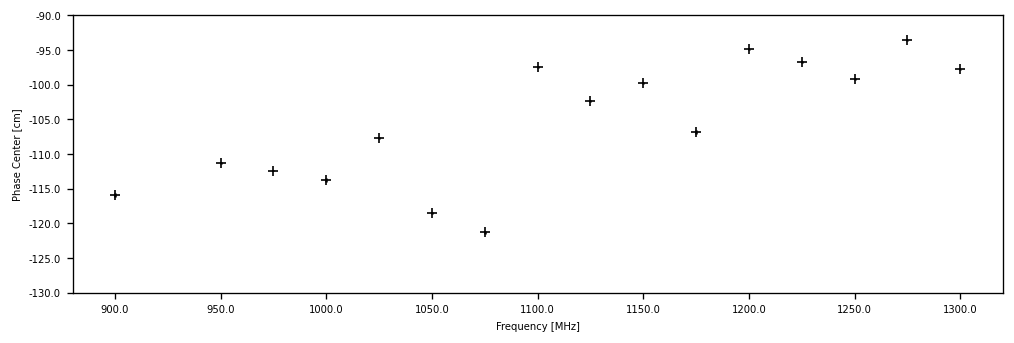

In [47]:
data = PC.best_fit.query("WEIGHT == 'Amplitude' & SMOOTH == False").groupby("FREQ")[["DZ_phys", "DZ_err_low_phys", "DZ_err_high_phys"]].mean().reset_index()
yerr_phys = data[["DZ_err_low_phys", "DZ_err_high_phys"]].apply(lambda val: np.abs(data.DZ_phys - val)).T.values
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.errorbar(data.FREQ * 1000, data.DZ_phys, yerr=yerr_phys, fmt="+", label="Phase Center", color="black")
ax.set_ylim(-130, -90)
ax.set_xlabel("Frequency [MHz]", fontsize=6)
ax.set_ylabel("Phase Center [cm]", fontsize=6)
ax.set_yticklabels(ax.get_yticks(), fontsize=6)
ax.set_xticklabels(ax.get_xticks(), fontsize=6)
plt.show();

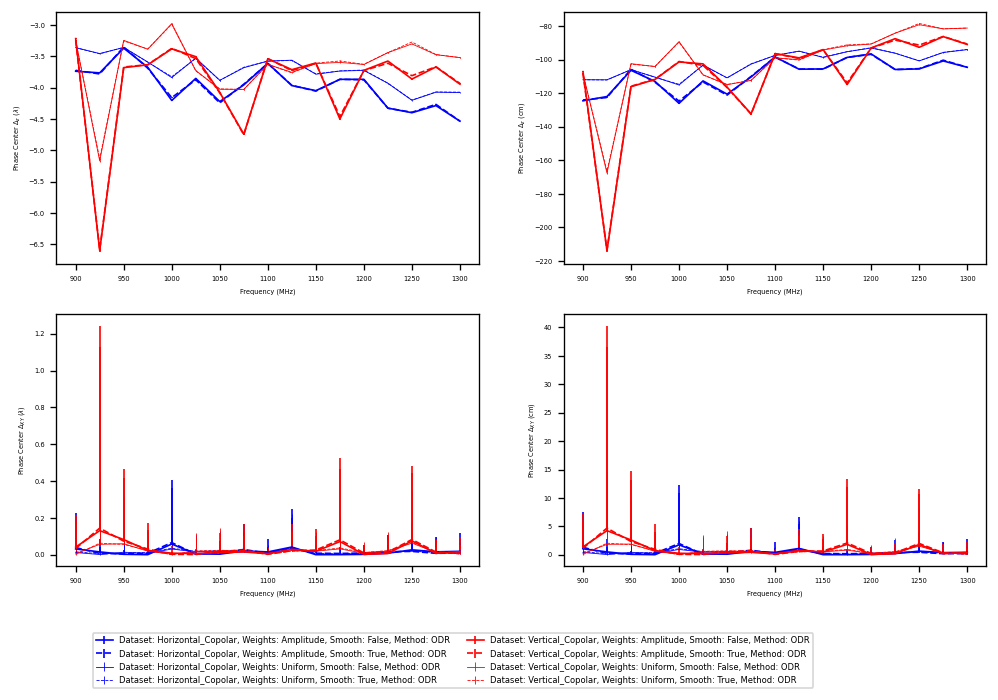

In [29]:
PC.plot_phase_center(size=(10, 6));

### Predicted vs Measured phase patterns

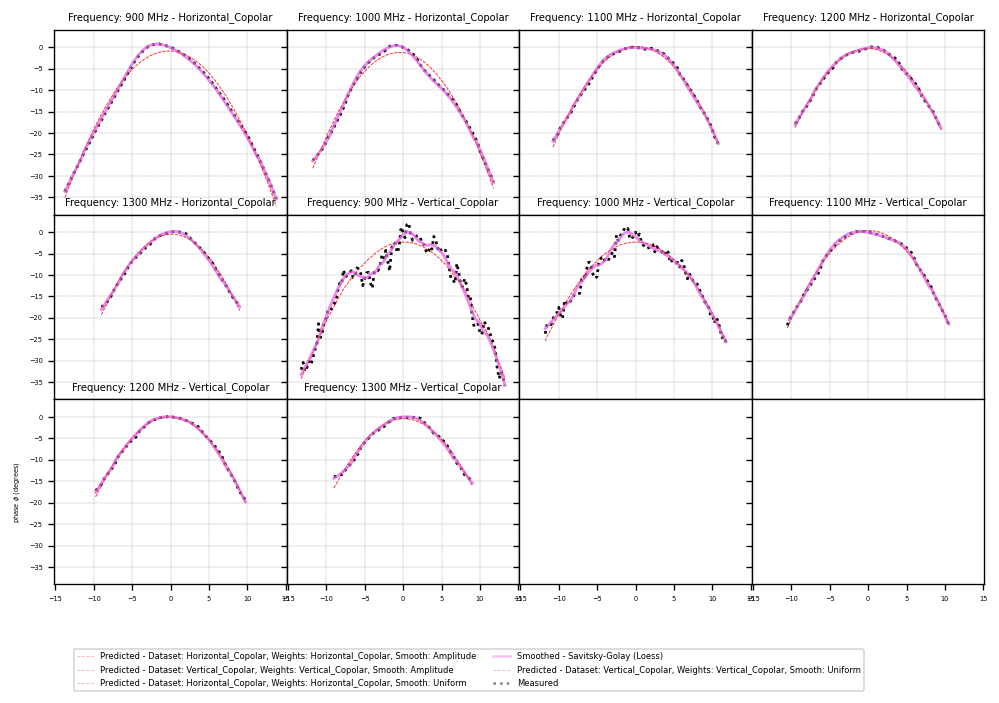

In [30]:
freqs = PC.data.FREQ.unique()[::4]
PC.plot_phases(freqs=freqs, size=(10, 6));

### Scores

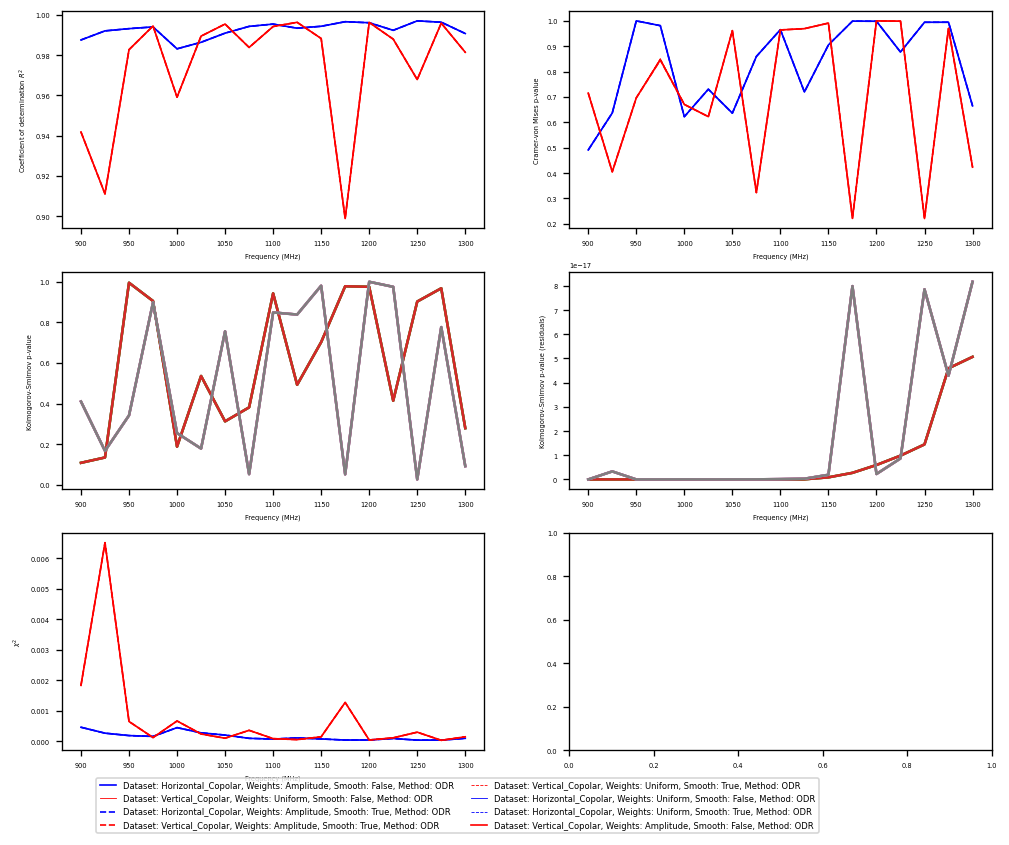

In [31]:
PC.plot_statistics(size=(10, 8));

### Quantile plot for predicted and measured phase distributions.

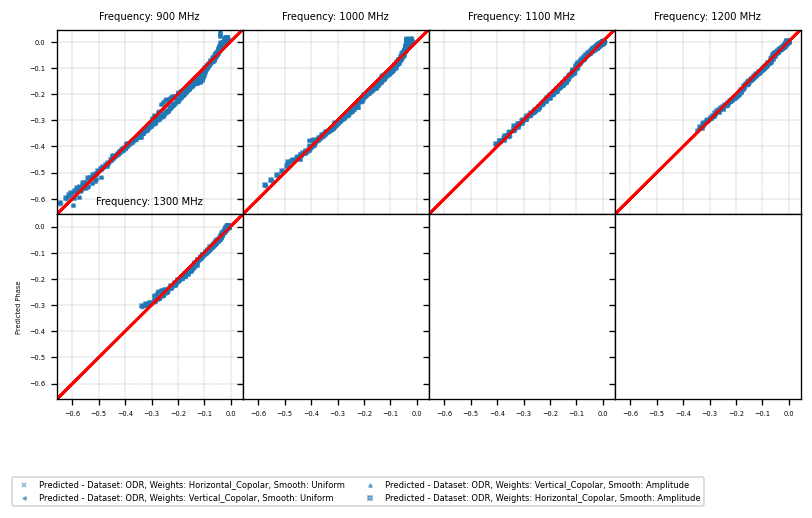

In [32]:
PC.plot_residuals(freqs=freqs);

### Quantile Plot for residuals.

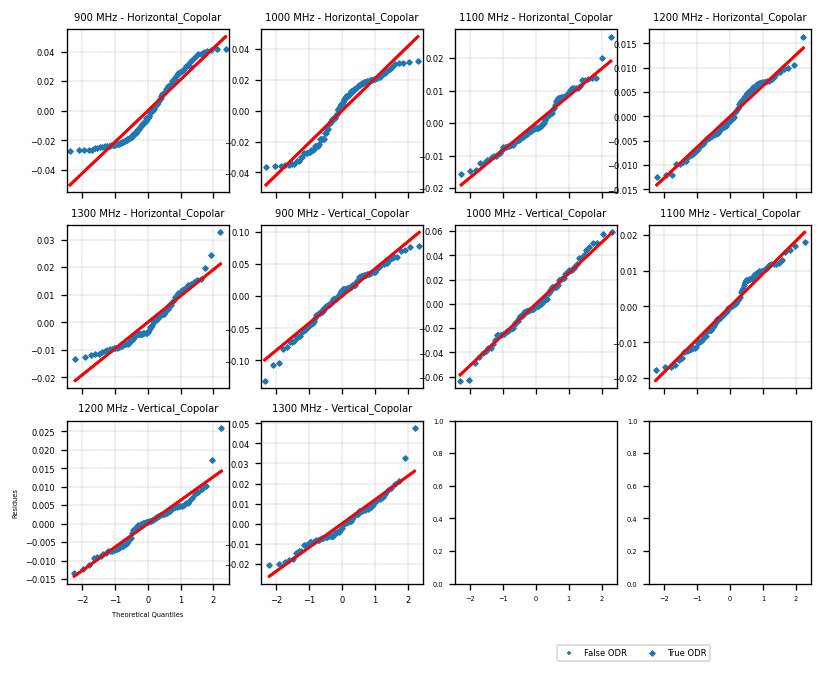

In [33]:
PC.plot_qq_residuals(freqs=freqs);

## Concluding Remarks

- Cramer Von Mises test shows the googdness of fit, validating the procedure.
- Coefficient of determination indicates a large fraction of measured variance explained by the model.
- Kolmogorov-Smirnof test for residuals indicate that the residuals are not normal distributed.
- Chi squared is too low, combined with the other metrics we should consider large sistematics.
- We did not consider uncertainties for the measured data.
- Smoothing the data did not improve the fit substantially.
- Amplitude weighting had a significat positive impact for the goodness of fit.
- For any future measurements we may observe the following:
  - Measurements for very large angle are waste of time.
  - Rotation in azimuth should be done with the least possible angular resolution.
  - Information regading angle measurement uncertanties is important to obtain a sensible result.
  - Phase uncertanties may be obtained by taking several measurements of phase for each angle. This is easy to implement with VNAs and do not take considerable time. This procedure offer a quantification of phase variance and allows to consider different statistical tests, notably, Lack of Fit Test, and allows us to separate statistical noise from sistematics.
  - Measurement in fresnel region will have strong sistematics and it is not clear if any conclusive result would be drawn from the data.

## Code Availability

https://github.com/barosil/phase_center